380.0 nm, level = None; 400.0 nm, level = None; 415.0 nm, level = None; 420.0 nm, level = None; 445.0 nm, level = None
460.0 nm, level = None; 480.0 nm, level = None; 500.0 nm, level = None; 520.0 nm, level = None; 530.0 nm, level = None
560.0 nm, level = None; 575.0 nm, level = None; 590.0 nm, level = None; 600.0 nm, level = None; 620.0 nm, level = None
640.0 nm, level = None; 660.0 nm, level = None; 680.0 nm, level = None; 700.0 nm, level = None; 715.0 nm, level = None
730.0 nm, level = None; 740.0 nm, level = None; 780.0 nm, level = None; 800.0 nm, level = None; 830.0 nm, level = None
850.0 nm, level = None; 880.0 nm, level = None; 900.0 nm, level = None; 940.0 nm, level = None; 975.0 nm, level = None

Voltage levels:  None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
30 channels
LED currents (mA):
	154.15	97.48	99.80	116.89	117.75
	103.05	237.74	354.94	253.61	405.

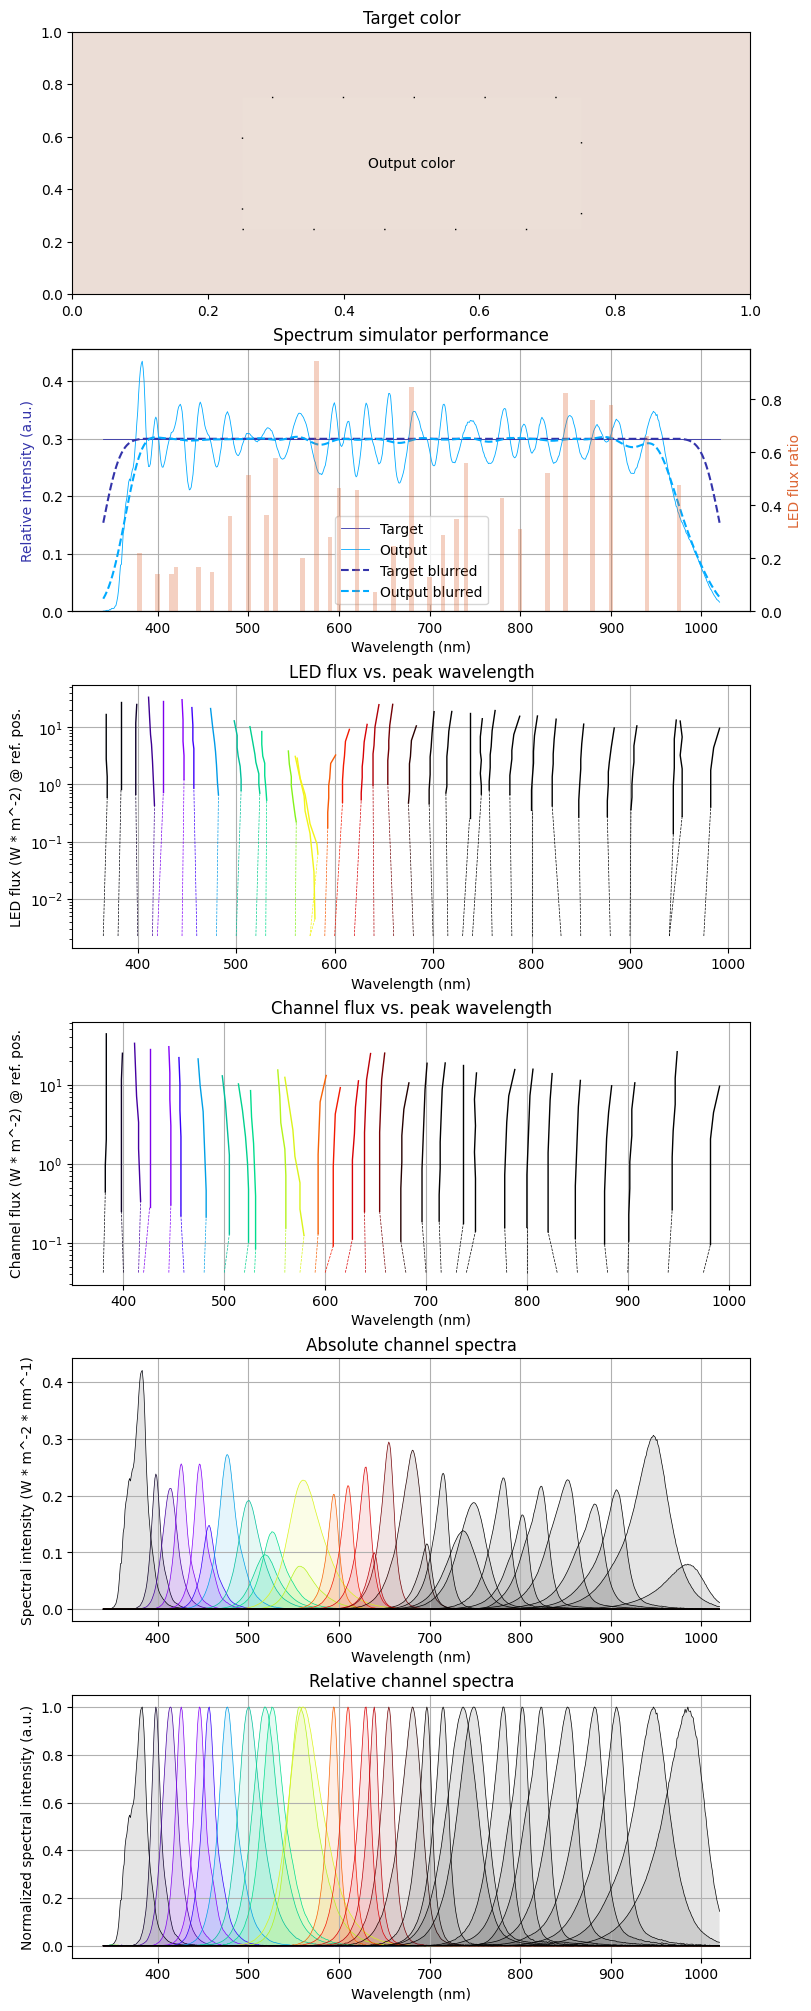

In [ ]:
import numpy as np
from util_led_spectrum import HyperspectralLight, read_spectrum_file, get_led_list_from_fit_results
from util_color_system import blackbody_radiation, cherenkov_radiation
from scipy.optimize import root_scalar
from scipy.integrate import trapezoid

use_measurements = True
# use_measurements = False

N_levels = 4096

# quantize_voltage = True
quantize_voltage = False

quantize_flux = True
# quantize_flux = False

# include_plain_diodes = True
include_plain_diodes = False

# uv_off = True
uv_off = False

flux_ratio_min = 5e-5
flux_ratio_max = 0.5  # with values greater than 0.5, the rectifier diodes may heat up significantly

output_gain = 0.3

R_wirings = 0.5  # Ohm
I_nominal = 0.7  # Amperes

I_max = 0.7  # Amperes

if include_plain_diodes:
    V_low_lim = 1.6
else:
    V_low_lim = 0.

blur_radius = 15  # nm
# blur_kernel = 0.5 * (1 + np.cos(np.pi * np.arange(-2 * blur_radius, 2 * blur_radius + 1) / (2 * blur_radius)))  # cosine kernel
blur_kernel = np.exp(-((np.arange(-blur_radius * 3, blur_radius * 3 + 1)) / blur_radius) ** 2 / 2)  # gaussian kernel
blur_kernel /= np.sum(blur_kernel)

if use_measurements:
    from LEDtestdata.fit_model import fit_model_pars, calc_channel_data, get_default_channel_list_from_fit_results
    fname_fit_results = fit_model_pars(mute=True)
    led_list = get_led_list_from_fit_results(fname_led_fit_results=fname_fit_results, I_nominal=I_nominal)
    led_tags = [led.tag for led in led_list]
    channel_list = get_default_channel_list_from_fit_results(fname_fit_results=fname_fit_results)
    # get the nominal wavelength of each led in led_list
    nom_wls_led = np.array([led.nominal_wavelength for led in led_list])
    # get the nominal wavelength of the first component in each channel in channel_list
    nom_wls_channel = np.array([led_list[led_tags.index(list(ch.keys())[0])].nominal_wavelength for ch in channel_list])

    wl_to_operate = 560
    channel_list[np.argmin(np.abs(nom_wls_channel - wl_to_operate))]\
        [led_list[np.argmin(np.abs(nom_wls_led - wl_to_operate))].tag] = 4  # change channel led count

    # delete the 575 nm Ruixiang channel
    channel_main_led_tags = [list(ch.keys())[0] for ch in channel_list]
    del channel_list[channel_main_led_tags.index('575 Ruixiang 2024-02-28')]
    # get the nominal wavelength of the first component in each channel in channel_list
    nom_wls_channel = np.array([led_list[led_tags.index(list(ch.keys())[0])].nominal_wavelength for ch in channel_list])

    channel_main_led_tags = [list(ch.keys())[0] for ch in channel_list]
    channel_list[channel_main_led_tags.index('575 Baideqi 2024-03-19')]\
        [led_list[np.argmin(np.abs(nom_wls_led - 575))].tag] = 4  # change channel led count

    wl_to_operate = 590
    channel_list[np.argmin(np.abs(nom_wls_channel - wl_to_operate))]\
        [led_list[np.argmin(np.abs(nom_wls_led - wl_to_operate))].tag] = 4  # change channel led count
    
    # wl_to_operate = 680
    # channel_list[np.argmin(np.abs(nom_wls_channel - wl_to_operate))]\
    #     [led_list[np.argmin(np.abs(nom_wls_led - wl_to_operate))].tag] = 2  # change channel led count

    # merge the 365 nm channel into the 380 nm channel
    channel_list[np.argmin(np.abs(nom_wls_channel - 380))] |= channel_list[np.argmin(np.abs(nom_wls_channel - 365))]
    del channel_list[np.argmin(np.abs(nom_wls_channel - 365))]
    # update the nominal wavelength of the first component in each channel in channel_list
    nom_wls_channel = np.array([led_list[led_tags.index(list(ch.keys())[0])].nominal_wavelength for ch in channel_list])

    # merge the 940 nm Taiyi 2024-03-19 channel into the 940 nm Jingzhong 2024-02-28 channel
    channel_main_led_tags = [list(ch.keys())[0] for ch in channel_list]
    id_ch_to_del = channel_main_led_tags.index('940 Taiyi 2024-03-19')
    channel_list[channel_main_led_tags.index('940 Jingzhong 2024-02-28')] |= channel_list[id_ch_to_del]
    del channel_list[id_ch_to_del]
    # update the nominal wavelength of the first component in each channel in channel_list
    nom_wls_channel = np.array([led_list[led_tags.index(list(ch.keys())[0])].nominal_wavelength for ch in channel_list])

    # delete the 760 nm channel
    del channel_list[np.argmin(np.abs(nom_wls_channel - 760))]
    # get the nominal wavelength of the first component in each channel in channel_list
    nom_wls_channel = np.array([led_list[led_tags.index(list(ch.keys())[0])].nominal_wavelength for ch in channel_list])

    # # delete UV channels
    # for i, wl in enumerate(reversed(nom_wls_channel)):
    #     if wl <= 400:
    #         del channel_list[np.argmin(np.abs(nom_wls_channel - wl))]
    # # get the nominal wavelength of the first component in each channel in channel_list
    # nom_wls_channel = np.array([led_list[led_tags.index(list(ch.keys())[0])].nominal_wavelength for ch in channel_list])

    fname_channel_data = calc_channel_data(channel_list=channel_list, 
                                           led_list=led_list, 
                                           flux_ratio_min=flux_ratio_min, flux_ratio_max=flux_ratio_max, 
                                           R_wirings=R_wirings, V_low_lim=V_low_lim)
    h_light = HyperspectralLight(min_wl=340, max_wl=1020)
else:
    h_light = HyperspectralLight(min_wl=340, max_wl=1020, led_data_path=None)
wavelengths = h_light._wavelengths

# # add LEDs to fill in the spectral gaps
# wls_to_add = [435, 465, 487, 533, 589, 625, 650, 670, 695, 710, 725, 775, 795, 815, 840, 870, 890, 920]
# wls_to_ref = [420, 480, 500, 520, 590, 620, 660, 680, 690, 715, 730, 780, 800, 820, 850, 880, 900, 900]
# wls_led_count = [1,  1,   1,   2,   4,   1,   1,   2,   1,   1,   1,   1,   1,   1,   1,   2,   1,   1]
# wls_led_mask = [ 0,  0,   0,   0,   1,   0,   0,   1,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]
# for i, wl_to_add in enumerate(wls_to_add):
#     if wls_led_mask[i] == 0:
#         continue
#     h_light.add_led(peak_wavelength=wl_to_add, id_led_ref=np.argmin(np.abs(h_light.all_nominal_wls - wls_to_ref[i])), 
#                     new_control_channel=True, N_new=wls_led_count[i])

# # measure or generate target
calibration_file = 'LEDtestdata/multiply_this_with_spectra_before_202403150108.csv'
# target_spectrum = blackbody_radiation(wavelength=wavelengths, temperature=3500, normalize=True)
# target_spectrum = cherenkov_radiation(wavelength=wavelengths)
target_spectrum = wavelengths * 0 + 1  # equi-power
# target_spectrum = read_spectrum_file(fname='sample spectra/SunsetOrdinary/merged_spectra_only.csv', wavelengths=wavelengths, intensity_column=150)
# target_spectrum = read_spectrum_file(fname='sample spectra/SunsetRed/merged_spectra_only.csv', wavelengths=wavelengths, intensity_column=120)
# target_spectrum = read_spectrum_file(fname='sample spectra/cloudy_daylight_20240307131758.csv', wavelengths=wavelengths, fname_calibration=calibration_file)
# target_spectrum = read_spectrum_file(fname='sample spectra/direct_sunlight_20240312123009.csv', wavelengths=wavelengths, fname_calibration=calibration_file)
# target_spectrum = read_spectrum_file(fname='sample spectra/gold_fluorescent_light_20240225194221.csv', wavelengths=wavelengths, fname_calibration=calibration_file)
# target_spectrum = read_spectrum_file(fname='sample spectra/green_leaf_under_cloudy_daylight_20240225160513.csv', wavelengths=wavelengths, fname_calibration=calibration_file)
# target_spectrum = read_spectrum_file(fname='sample spectra/high_pressure_sodium_light_20240225193613.csv', wavelengths=wavelengths, fname_calibration=calibration_file)
# target_spectrum = read_spectrum_file(fname='sample spectra/peanut_oil_under_cloudy_daylight_20240307131813.csv', wavelengths=wavelengths, fname_calibration=calibration_file)
# target_spectrum = read_spectrum_file(fname='sample spectra/rapseed_oil_under_cloudy_daylight_20240307131622.csv', wavelengths=wavelengths, fname_calibration=calibration_file)
# target_spectrum = read_spectrum_file(fname='sample spectra/warm_LED_light_20240314182106.csv', wavelengths=wavelengths, fname_calibration=calibration_file)
# target_spectrum = read_spectrum_file(fname='sample spectra/white_fluorescent_light_20240225193438.csv', wavelengths=wavelengths, fname_calibration=calibration_file)
# target_spectrum = read_spectrum_file(fname='sample spectra/daylight_thru_napkin_dragonfruit_20240315131135.csv', wavelengths=wavelengths)
# target_spectrum *= read_spectrum_file(fname='sample spectra/dragon_fruit_pink_transmittance.csv', wavelengths=wavelengths)
# target_spectrum *= read_spectrum_file(fname='sample spectra/QB19_transmittance_resampled.csv', wavelengths=wavelengths)
# target_spectrum *= read_spectrum_file(fname='sample spectra/QB21_transmittance_resampled.csv', wavelengths=wavelengths)
# target_spectrum *= read_spectrum_file(fname='sample spectra/CB590_transmittance.csv', wavelengths=wavelengths)

target_spectrum_blurred = np.convolve(target_spectrum, blur_kernel, mode='same')
intensity_adjusting_factor = 1. / np.max(target_spectrum_blurred) * output_gain
target_spectrum *= intensity_adjusting_factor
target_spectrum_blurred *= intensity_adjusting_factor

# fit spectrum
h_light.min_wl = 350
h_light.max_wl = 980
channel_flux_ratios = h_light.calc_channel_flux_ratios(wavelengths=wavelengths, target_spectrum=target_spectrum, blur_radius=5)
h_light.min_wl = 340
h_light.max_wl = 1020
channel_flux_ratios = np.minimum(min(1., I_max / I_nominal), channel_flux_ratios)
# channel_flux_ratios = channel_flux_ratios * 0 + 1
if uv_off:
    channel_flux_ratios[:1] = 0.

voltages = np.array([h_light.get_channel_voltage(id_channel=i) for i in range(h_light.N_channels)])

if quantize_voltage:
    # calculate voltages
    channel_flux_ratios = np.clip(channel_flux_ratios, flux_ratio_min, flux_ratio_max)  # limit to realizable power
    V_mins = np.array([h_light.get_channel_voltage(id_channel=i, flux_ratio=flux_ratio_min) for i in range(h_light.N_channels)])
    V_maxs = np.array([h_light.get_channel_voltage(id_channel=i, flux_ratio=flux_ratio_max) for i in range(h_light.N_channels)])
    # quantize voltage levels
    voltage_levels = np.floor(np.clip((voltages - V_mins) / (V_maxs - V_mins), 0., 1.) * N_levels + 0.499)
    voltage_levels = np.array(voltage_levels, dtype=int)

    # override voltage control 2
    # voltage_levels *= 0
    # voltage_levels[18] = N_levels
    # voltage_levels += N_levels
    if uv_off:
        voltage_levels[:1] = 0  # UV off

    # simulate voltages and fluxes
    voltages = V_mins + voltage_levels / N_levels * (V_maxs - V_mins)
    for i in range(h_light.N_channels):
        def flux_to_channel_voltage_error(lnflux_ratio):
            flux_ratio = np.exp(lnflux_ratio)
            voltage_ch = h_light.get_channel_voltage(id_channel=i, flux_ratio=flux_ratio)
            voltage_err = voltage_ch - voltages[i]
            return voltage_err
        res = root_scalar(flux_to_channel_voltage_error, 
                          bracket=(np.log(1e-10), np.log(3.)), 
                          method='brentq').root
        channel_flux_ratios[i] = np.exp(res)
else:
    voltage_levels = [None, ] * h_light.N_leds

if use_measurements:
    # simulate output spectrum
    output_spectrum = h_light.output_spectrum(channel_flux_ratios=channel_flux_ratios)[1]
    wl_lvl_str = ''
    ch_nom_wls = h_light.get_channel_nom_wls()
    for i in range(h_light.N_channels):
        wl_lvl_str += str(ch_nom_wls[i]) + ' nm, level = ' + str(voltage_levels[i])
        if (i+1) % 5 == 0:
            wl_lvl_str += '\n'
        else:
            wl_lvl_str += '; '
    print(wl_lvl_str)
    print('Voltage levels: ', ','.join([str(x) for x in voltage_levels]))
    print(h_light.N_channels, 'channels')
else:
    # turn off anti-edgefluctuation virtual LEDs
    channel_flux_ratios[:2] = 0.
    channel_flux_ratios[-2:] = 0.
    # simulate output spectrum
    output_spectrum = h_light.output_spectrum(channel_flux_ratios=channel_flux_ratios)[1]
    wl_lvl_str = ''
    for i in range(2, h_light.N_leds-2):
        wl_lvl_str += str(h_light.led_nominal_wls[i]) + ' nm, level = ' + str(voltage_levels[i])
        if (i+1) % 5 == 0:
            wl_lvl_str += '\n'
        else:
            wl_lvl_str += '; '
    print(wl_lvl_str)
    print('Voltage levels: ', ','.join([str(x) for x in voltage_levels[2:-2]]))
    print(h_light.N_leds - 4, 'LEDs')

if quantize_flux:
    channel_flux_ratios = np.floor(0.5 + channel_flux_ratios * N_levels) / N_levels

I_channels = np.array([h_light.get_channel_current(id_channel=i, flux_ratio=channel_flux_ratios[i])
                       for i in range(h_light.N_channels)])
print('LED currents (mA):\n\t' + '\t'.join([('%.2f') % (1e3*x) + '\n'*(i%5==4) for i, x in enumerate(I_channels)]))
print('Total power LED + plain diodes (W):', np.sum(I_channels * voltages))

if uv_off:
    wl_err_eval_min = 395
else:
    wl_err_eval_min = 370
wl_err_eval_max = 980

print('Spectral RMSE:', int(0.499 + 100 * np.sqrt(np.sum(np.logical_and(wl_err_eval_min <= wavelengths, wavelengths <= wl_err_eval_max) *
                                                           (output_spectrum - target_spectrum)**2) / np.sum(target_spectrum**2))), '%')


output_spectrum_blurred = np.convolve(output_spectrum, blur_kernel, mode='same')

print('Spectral RMSE blurred:', int(0.499 + 100 * np.sqrt(np.sum(np.logical_and(wl_err_eval_min+blur_radius <= wavelengths, 
                                                                                wavelengths <= wl_err_eval_max-blur_radius) *
                                                           (output_spectrum_blurred - target_spectrum_blurred)**2) / np.sum(target_spectrum_blurred**2))
                                    ), '%, blur radius =', blur_radius, 'nm')
from util_plot import plot_results, show_plot
fig, axs = plot_results(h_light=h_light, target_spectrum=target_spectrum, output_spectrum=output_spectrum, 
             wavelengths=wavelengths,
             target_spectrum_blurred=target_spectrum_blurred, output_spectrum_blurred=output_spectrum_blurred,
             channel_flux_ratios=channel_flux_ratios)
show_plot()
